## DRILL: Third Attempt

So here's your task. Get rid of as much data as possible without dropping below an average of 90% accuracy in a 10-fold cross validation.

You'll want to do a few things in this process. First, dive into the data that we have and see which features are most important. This can be the raw features or the generated dummies. You may want to use PCA or correlation matrices.

Can you do it without using anything related to payment amount or outstanding principal? How do you know?

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dython.nominal import associations

from sklearn import ensemble
from sklearn.model_selection import cross_val_score

sns.set_style('dark')
plt.style.use('dark_background')

In [5]:
# Replace the path with the correct path for your data.
y2015 = pd.read_csv('https://www.dropbox.com/s/0so14yudedjmm5m/LoanStats3d.csv?dl=1',skipinitialspace=True,header=1)

# Note the warning about dtypes.

/Users/DanCassin/Development/python/python/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (0,19,55) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [6]:
y2015.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,68009401,72868139.0,16000.0,16000.0,16000.0,60 months,14.85%,379.39,C,C5,...,0.0,2.0,78.9,0.0,0.0,2.0,298100.0,31329.0,281300.0,13400.0
1,68354783,73244544.0,9600.0,9600.0,9600.0,36 months,7.49%,298.58,A,A4,...,0.0,2.0,100.0,66.7,0.0,0.0,88635.0,55387.0,12500.0,75635.0
2,68466916,73356753.0,25000.0,25000.0,25000.0,36 months,7.49%,777.55,A,A4,...,0.0,0.0,100.0,20.0,0.0,0.0,373572.0,68056.0,38400.0,82117.0
3,68466961,73356799.0,28000.0,28000.0,28000.0,36 months,6.49%,858.05,A,A2,...,0.0,0.0,91.7,22.2,0.0,0.0,304003.0,74920.0,41500.0,42503.0
4,68495092,73384866.0,8650.0,8650.0,8650.0,36 months,19.89%,320.99,E,E3,...,0.0,12.0,100.0,50.0,1.0,0.0,38998.0,18926.0,2750.0,18248.0


In [7]:
# Remove two summary rows at the end that don't actually contain data.
y2015 = y2015[:-2]

In [8]:
# Convert ID and Interest Rate to numeric.
y2015['id'] = pd.to_numeric(y2015['id'], errors='coerce')
y2015['int_rate'] = pd.to_numeric(y2015['int_rate'].str.strip('%'), errors='coerce')

# Drop other columns with many unique variables
y2015.drop(['url', 'emp_title', 'zip_code', 'earliest_cr_line', 'revol_util',
            'sub_grade', 'addr_state', 'desc'], 1, inplace=True)

In [19]:
numerics = y2015.select_dtypes('float64').columns
categoricals = y2015.select_dtypes('object').columns

In [17]:
y2015.iloc[:,50:].head()

,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,31329.0,1.0,2.0,1.0,2.0,6.0,12221.0,91.0,1.0,4.0,...,0.0,2.0,78.9,0.0,0.0,2.0,298100.0,31329.0,281300.0,13400.0
1,55387.0,0.0,3.0,0.0,0.0,47.0,47665.0,43.0,2.0,2.0,...,0.0,2.0,100.0,66.7,0.0,0.0,88635.0,55387.0,12500.0,75635.0
2,305781.0,0.0,3.0,0.0,1.0,13.0,47194.0,58.0,0.0,1.0,...,0.0,0.0,100.0,20.0,0.0,0.0,373572.0,68056.0,38400.0,82117.0
3,221110.0,0.0,2.0,0.0,0.0,27.0,23413.0,55.0,0.0,1.0,...,0.0,0.0,91.7,22.2,0.0,0.0,304003.0,74920.0,41500.0,42503.0
4,18926.0,6.0,1.0,0.0,1.0,19.0,9358.0,51.0,12.0,16.0,...,0.0,12.0,100.0,50.0,1.0,0.0,38998.0,18926.0,2750.0,18248.0


In [40]:
len(numerics)

86

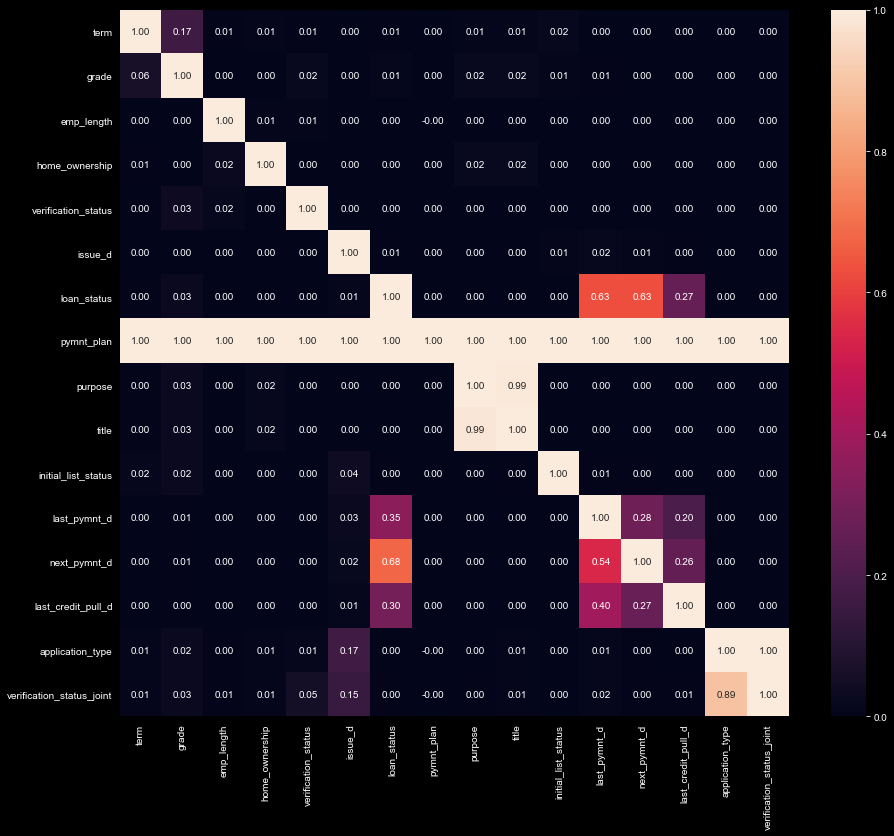

In [55]:
# Using dython to plot associations between the categoricals

fig, ax = plt.subplots(figsize=(15,13))
associations(y2015[categoricals], theil_u=True, ax=ax)

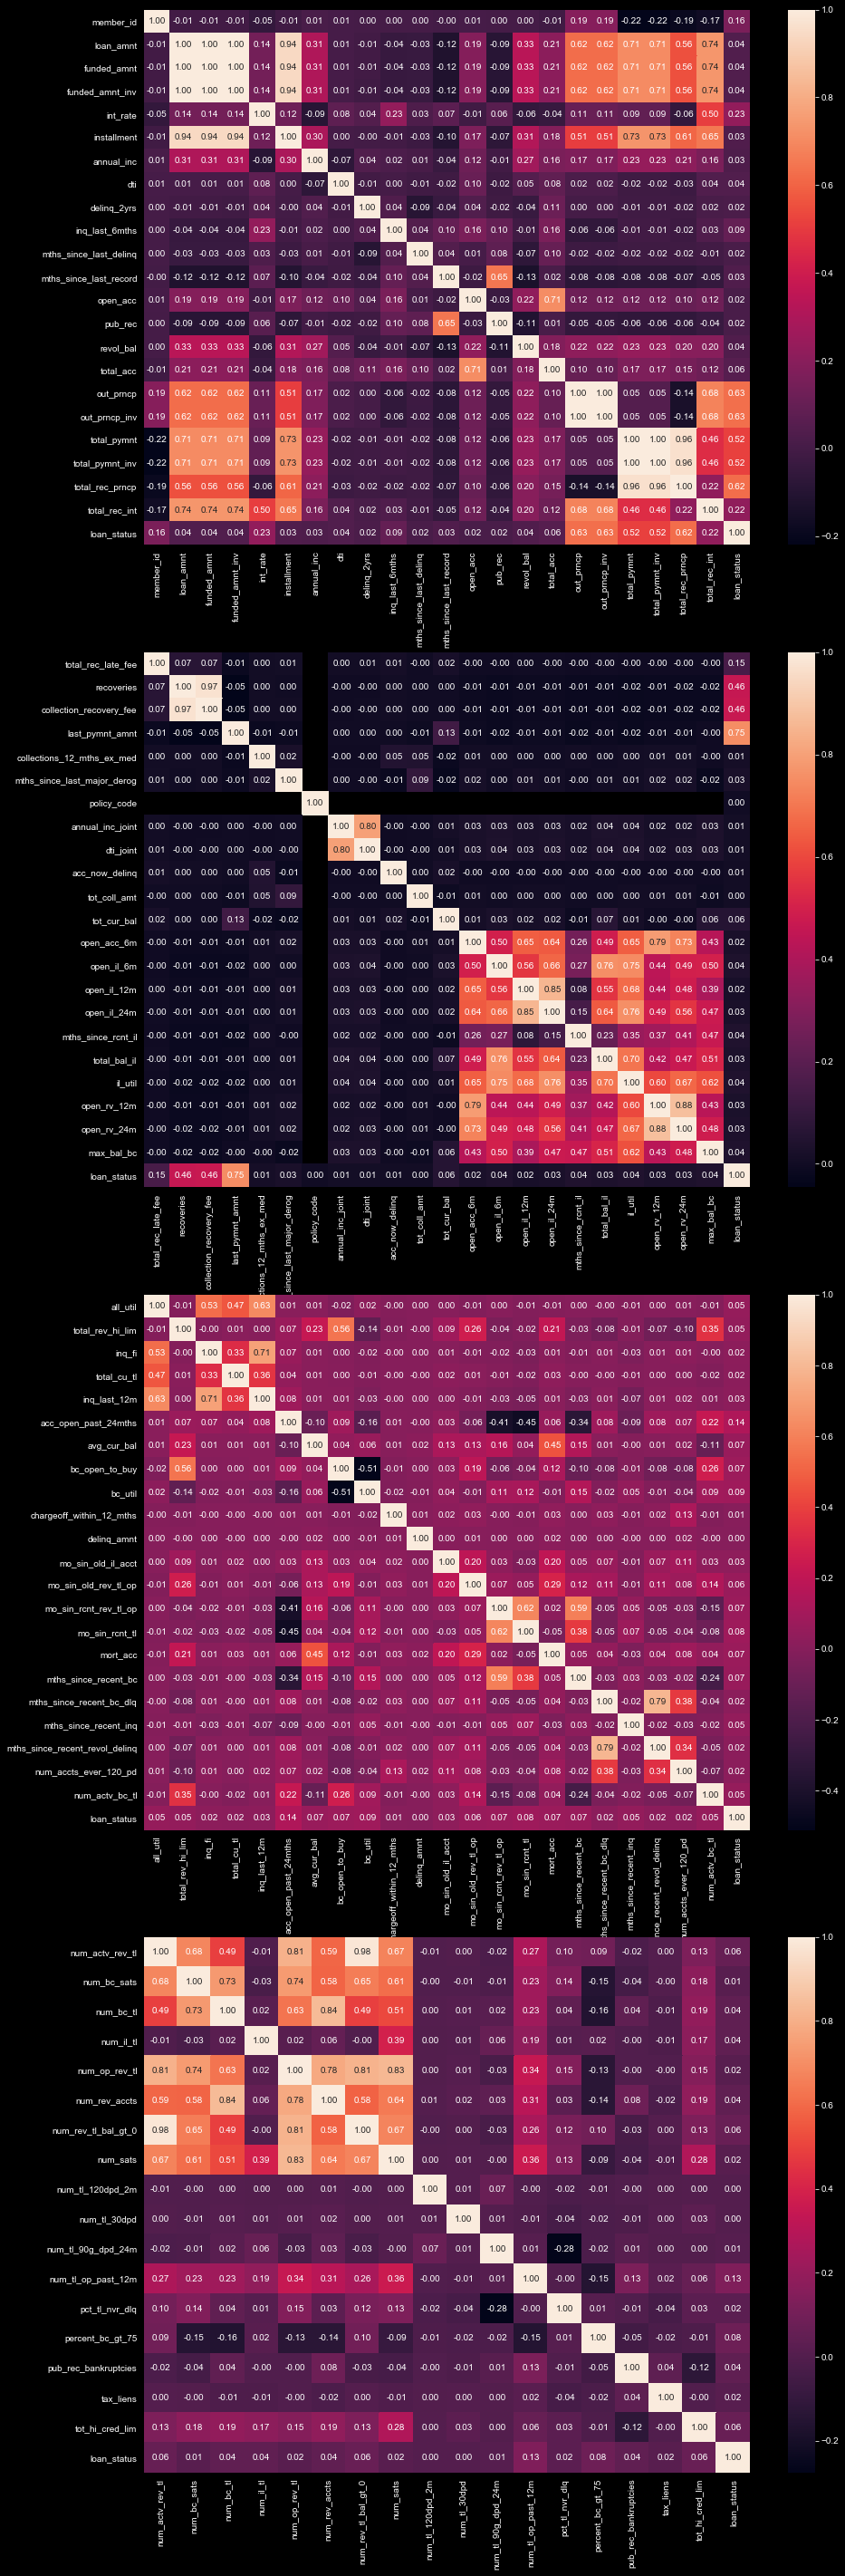

In [48]:
numeric_corr1 = pd.concat([y2015[numerics].iloc[:,:22], y2015['loan_status']], axis=1)
numeric_corr2 = pd.concat([y2015[numerics].iloc[:,22:44], y2015['loan_status']], axis=1)
numeric_corr3 = pd.concat([y2015[numerics].iloc[:,44:66], y2015['loan_status']], axis=1)
numeric_corr4 = pd.concat([y2015[numerics].iloc[:,66:83], y2015['loan_status']], axis=1)

fig, ax = plt.subplots(figsize=(15,50))

ax1 = plt.subplot(4,1,1)
associations(numeric_corr1, ax=ax1)

ax2 = plt.subplot(4,1,2)
associations(numeric_corr2, ax=ax2)

ax3 = plt.subplot(4,1,3)
associations(numeric_corr3, ax=ax3)

ax4 = plt.subplot(4,1,4)
associations(numeric_corr4, ax=ax4)

In [63]:
#Creating a reduced df from the correlations and associations

X = y2015[['out_prncp','out_prncp_inv','total_rec_prncp','last_pymnt_amnt', 'next_pymnt_d']]
X = pd.get_dummies(X)
y = y2015['loan_status']

In [67]:
rfc = ensemble.RandomForestClassifier(n_estimators=100)

cross_val_score(rfc, X, y, cv=10)
#array([0.86559012, 0.9524341 , 0.93611969, 0.95369271, 0.94469247,
#       0.94647225, 0.91488755, 0.93953787, 0.94846707, 0.95649386])

array([0.86559012, 0.9524341 , 0.93611969, 0.95369271, 0.94469247,
       0.94647225, 0.91488755, 0.93953787, 0.94846707, 0.95649386])